In [91]:
import sys
import os
import pandas as pd
import yfinance as yf
import warnings

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

from yahooquery import Ticker
import requests

import datetime

warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [92]:
import gspread

# gc = gspread.service_account(filename='stocksflags-ec5c40f2f2ee.json')
gc = gspread.service_account(filename='rational-diode-456114-m0-79243525427e.json')


ginzu_spreadsheet_link = 'https://docs.google.com/spreadsheets/d/1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks/edit?usp=sharing'
pricer = gc.open_by_url(ginzu_spreadsheet_link)
input_worksheet = pricer.get_worksheet(0)
valuation_worksheet = pricer.get_worksheet(1)

In [93]:
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'rational-diode-456114-m0-79243525427e.json'

spreadsheet_id = '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks'
sheet_name = 'Input sheet'

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)

In [94]:
def get_dropdown_options(spreadsheet_id: str, sheet_name: str, cell: str) -> list:
    """
    Given a spreadsheet ID, sheet name, and cell (e.g., 'B7'),
    returns the dropdown options (either hardcoded or from a range).
    """
    range_name = f"'{sheet_name}'!{cell}"
    
    try:
        response = service.spreadsheets().get(
            spreadsheetId=spreadsheet_id,
            ranges=[range_name],
            includeGridData=True,
            fields='sheets.data.rowData.values.dataValidation'
        ).execute()

        validation = response['sheets'][0]['data'][0]['rowData'][0]['values'][0]['dataValidation']
        condition = validation['condition']
        dropdown_values = [v['userEnteredValue'] for v in condition.get('values', [])]

        dropdown_ref = dropdown_values[0]
        if dropdown_ref.startswith("="):
            raw_ref = dropdown_ref.lstrip("=").replace("'", "")
            ref_sheet, ref_range = raw_ref.split("!")

            country_resp = service.spreadsheets().values().get(
                spreadsheetId=spreadsheet_id,
                range=f"{ref_sheet}!{ref_range}"
            ).execute()

            return [row[0].strip() for row in country_resp.get("values", []) if row and row[0].strip()]
        else:
            return dropdown_values

    except (KeyError, IndexError):
        print(f"No dropdown (data validation) found at {sheet_name}!{cell}.")
        return []


In [150]:
def get_latest_10k_financials(symbol):
    ticker = Ticker(symbol)

    # Annual financials
    income = ticker.income_statement(frequency='a')
    balance = ticker.balance_sheet(frequency='a')

    # Reset index to get access to 'asOfDate' and other columns
    income = income.reset_index()
    balance = balance.reset_index()

    # Filter for the most recent 12M data
    income_12m = income[income['periodType'] == '12M']
    balance_12m = balance[balance['periodType'] == '12M']

    # Sort and get the most recent fiscal year
    latest_income = income_12m.sort_values('asOfDate').iloc[-1]
    latest_balance = balance_12m.sort_values('asOfDate').iloc[-1]

    # Get the previous fiscal year for comparison
    prev_income = income_12m.sort_values('asOfDate').iloc[-2] if len(income_12m) > 1 else None
    prev_balance = balance_12m.sort_values('asOfDate').iloc[-2] if len(balance_12m) > 1 else None

    # Calculate years since last 10-K
    if prev_income is not None:
        years_since_last_10k = (latest_income["asOfDate"] - prev_income["asOfDate"]).days / 365
    else:
        years_since_last_10k = None

    # Extract Book Value of Equity (OrdinarySharesNumber)
    latest_book_value_of_equity = latest_balance.get("OrdinarySharesNumber")
    prev_book_value_of_equity = prev_balance.get("OrdinarySharesNumber") if prev_balance is not None else None

    # Extract Minority Interests
    latest_minority_interests = latest_balance.get("TotalEquityGrossMinorityInterest") or latest_balance.get("TotalLiabilitiesNetMinorityInterest") or latest_balance.get("TotalNonCurrentLiabilitiesNetMinorityInterest")
    prev_minority_interests = prev_balance.get("TotalEquityGrossMinorityInterest") or prev_balance.get("TotalLiabilitiesNetMinorityInterest") or prev_balance.get("TotalNonCurrentLiabilitiesNetMinorityInterest") if prev_balance is not None else None

    latest_investments = (
        latest_balance.get("ShortTermInvestments")
        or latest_balance.get("LongTermInvestments")
        or latest_balance.get("InvestmentsAndAdvances")
    )
    prev_investments = (
        prev_balance.get("ShortTermInvestments")
        or prev_balance.get("LongTermInvestments")
        or prev_balance.get("InvestmentsAndAdvances")
    ) if prev_balance is not None else None

    # R&D and operating lease flags
    r_and_d_expenses = "R&D" in latest_income.index and latest_income["R&D"] > 0
    operating_lease_commitments = "OperatingLease" in latest_balance.index

    # Shares outstanding and stock price
    shares_outstanding = latest_balance.get("OrdinarySharesNumber")
    current_stock_price = ticker.history(period='1d')['close'].iloc[-1] if not ticker.history(period='1d').empty else None

    # Use TaxRateForCalc for effective tax rate
    effective_tax_rate = latest_income.get("TaxRateForCalcs")

    # Use static U.S. corporate rate as marginal tax rate
    marginal_tax_rate = 0.21

    risk_free_rate = 0.0427

    return {
        "B11": latest_income.get("TotalRevenue"),
        "C11": prev_income.get("TotalRevenue") if prev_income is not None else None,
        "D11": years_since_last_10k,
        "B12": latest_income.get("EBIT"),
        "C12": prev_income.get("EBIT") if prev_income is not None else None,
        "B13": latest_income.get("InterestExpense"),
        "C13": prev_income.get("InterestExpense") if prev_income is not None else None,
        "B14": latest_book_value_of_equity,
        "C14": prev_book_value_of_equity,
        "B15": latest_balance.get("TotalDebt"),
        "C15": prev_balance.get("TotalDebt") if prev_balance is not None else None,
        "B16": "Yes" if r_and_d_expenses else "No",
        "B17": "Yes" if operating_lease_commitments else "No",
        "B18": latest_balance.get("CashAndCashEquivalents"),
        "C18": prev_balance.get("CashAndCashEquivalents") if prev_balance is not None else None,
        "B19": latest_investments,
        "C19": prev_investments,
        "B20": latest_minority_interests,
        "C20": prev_minority_interests,
        "B21": shares_outstanding,
        "B22": current_stock_price,
        "B23": effective_tax_rate,
        "B24": marginal_tax_rate,
        "B33": risk_free_rate
    }

In [151]:
company_ticker = input("Enter the company ticker: ")

In [152]:
financials = get_latest_10k_financials(company_ticker)

In [153]:
financials

{'B11': 245122000000.0,
 'C11': 211915000000.0,
 'D11': 1.0027397260273974,
 'B12': 110722000000.0,
 'C12': 91279000000.0,
 'B13': 2935000000.0,
 'C13': 1968000000.0,
 'B14': 7434138859.0,
 'C14': 7432000000.0,
 'B15': 67127000000.0,
 'C15': 59965000000.0,
 'B16': 'No',
 'B17': 'No',
 'B18': 18315000000.0,
 'C18': 34704000000.0,
 'B19': 14600000000.0,
 'C19': 9879000000.0,
 'B20': 268477000000.0,
 'C20': 206223000000.0,
 'B21': 7434138859.0,
 'B22': 391.8500061035156,
 'B23': 0.182,
 'B24': 0.21,
 'B33': 0.0427}

## Date of Valuation and Company Name

In [122]:
def retrieve_date():
    valuation_date = datetime.datetime.today()
    formatted_date = valuation_date.strftime('%b-%d')
    return formatted_date

In [123]:
def get_company_name(symbol: str) -> str:
    t = Ticker(symbol)
    try:
        name = t.quote_type[symbol]['longName']
    except (KeyError, TypeError):
        raise ValueError(f"Could not retrieve company name for symbol: {symbol}")
    
    return name

In [124]:
date_of_valuation = retrieve_date()
company_name = get_company_name(company_ticker)
input_worksheet.update('B3', [[date_of_valuation]])
input_worksheet.update('B4', [[company_name]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1387689903.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B3', [[date_of_valuation]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1387689903.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B4', [[company_name]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B4",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Country of Incorporation, Industry (Global) and Industry (US)

In [125]:
def prompt_user_choice(options_list, prompt_message="Please choose an option:"):
    print("\nYou can type part of the name to search for matches.")
    print("Example: typing 'tech' will show 'Technology', 'Biotech', etc.\n")

    while True:
        search_input = input(f"{prompt_message} (type to search): ").strip().lower()
        
        matching_options = [opt for opt in options_list if search_input in opt.lower()]
        
        if not matching_options:
            print("No matches found. Please try again.")
            continue

        print("\nMatches found:")
        for idx, opt in enumerate(matching_options[:10], start=1):
            print(f"{idx}. {opt}")
        
        if len(matching_options) > 10:
            print(f"...and {len(matching_options) - 10} more matches.\n")
        else:
            print("") 

        selected_option = input("Type your exact choice from the matches above: ").strip()
        selected_exact = [opt for opt in matching_options if opt.lower() == selected_option.lower()]
        
        if selected_exact:
            return selected_exact[0]
        else:
            print("Invalid selection from matches. Please try again.\n")



In [126]:
country_names = get_dropdown_options(spreadsheet_id, sheet_name, 'B7')
us_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B8')
global_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B9')

In [127]:
country_names

['Abu Dhabi',
 'Albania',
 'Algeria',
 'Andorra (Principality of)',
 'Angola',
 'Anguilla',
 'Antigua & Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo (Democratic Republic of)',
 'Congo (Republic of)',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Falkland Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guernsey (St

In [ ]:
us_industry

In [ ]:
global_industry

In [106]:
country = prompt_user_choice(country_names, "Choose a country from the list above:")


You can type part of the name to search for matches.
Example: typing 'tech' will show 'Technology', 'Biotech', etc.


Matches found:
1. United States



In [107]:
us_industry_choice = prompt_user_choice(us_industry, "Choose a US industry from the list above:")


You can type part of the name to search for matches.
Example: typing 'tech' will show 'Technology', 'Biotech', etc.


Matches found:
1. Software (Entertainment)
2. Software (Internet)
3. Software (System & Application)



In [ ]:
global_industry_choice = prompt_user_choice(global_industry, "Choose a Global industry from the list above:")

In [110]:
input_worksheet.update('B7', [[country]])
input_worksheet.update('B8', [[us_industry_choice]])
input_worksheet.update('B9', [[global_industry_choice]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2968613820.py:1: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B7', [[country]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2968613820.py:2: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B8', [[us_industry_choice]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2968613820.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B9', [[global_industry_choice]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B9",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Years Since Last 10K

In [128]:
years_since_last_10k = financials["D11"]
input_worksheet.update('D11',[[years_since_last_10k]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2544386389.py:2: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('D11',[[years_since_last_10k]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!D11",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Revenues (Most Recent 12 Months, Last 10K)

In [129]:
current_revenues = financials["B11"]/10000000
last_10k_revenues = financials["C11"]/10000000
input_worksheet.update('B11', [[current_revenues]])
input_worksheet.update('C11', [[last_10k_revenues]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/816528849.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B11', [[current_revenues]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/816528849.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C11', [[last_10k_revenues]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C11",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Operating Income / EBIT (Most Recent 12 Months, Last 10K)

In [130]:
current_operating_income = financials["B12"]/10000000
last_10k_operating_income = financials["C12"]/10000000
input_worksheet.update('B12', [[current_operating_income]])
input_worksheet.update('C12', [[last_10k_operating_income]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2793727140.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B12', [[current_operating_income]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2793727140.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C12', [[last_10k_operating_income]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C12",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Interest Expense (Most Recent 12 Months, Last 10K)

In [131]:
current_interest_expense = financials["B13"]/10000000
last_10k_interest_expense = financials["C13"]/10000000
input_worksheet.update('B13', [[current_interest_expense]])
input_worksheet.update('C13', [[last_10k_interest_expense]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1258613870.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B13', [[current_interest_expense]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1258613870.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C13', [[last_10k_interest_expense]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C13",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Book Value of Equity (Most Recent 12 Months, Last 10K)

In [132]:
current_book_value_of_equity = financials["B14"]/10000000
last_10k_book_value_of_equity = financials["C14"]/10000000
input_worksheet.update('B14', [[current_book_value_of_equity]])
input_worksheet.update('C14', [[last_10k_book_value_of_equity]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2515169866.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B14', [[current_book_value_of_equity]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2515169866.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C14', [[last_10k_book_value_of_equity]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C14",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Book Value of Debt (Most Recent 12 Months, Last 10K)

In [133]:
current_book_value_of_debt = financials["B15"]/10000000
last_10k_book_value_of_debt = financials["C15"]/10000000
input_worksheet.update('B15', [[current_book_value_of_debt]])
input_worksheet.update('C15', [[last_10k_book_value_of_debt]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2317523367.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B15', [[current_book_value_of_debt]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2317523367.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C15', [[last_10k_book_value_of_debt]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C15",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## R&D Expenses to Capitalize + Operating Lease Commitments

In [134]:
r_and_d = financials["B16"]
operating_lease_commitments = financials["B17"]
input_worksheet.update('B16', [[r_and_d]])
input_worksheet.update('B17', [[operating_lease_commitments]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1234275495.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B16', [[r_and_d]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1234275495.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B17', [[operating_lease_commitments]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B17",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Cash and Marketable Securities (Most Recent 12 Months, Last 10K)

In [135]:
current_cash_and_marketable_securities = financials["B18"]/10000000
last_10k_cash_and_marketable_securities = financials["C18"]/10000000
input_worksheet.update('B18', [[current_cash_and_marketable_securities]])
input_worksheet.update('C18', [[last_10k_cash_and_marketable_securities]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1215311087.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B18', [[current_cash_and_marketable_securities]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1215311087.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C18', [[last_10k_cash_and_marketable_securities]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C18",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Investments (Most Recent 12 Months, Last 10K)

In [146]:
cross_holdings_and_other_non_operating_assets = financials["B19"]/10000000
last_10k_cross_holdings_and_other_non_operating_assets = financials["C19"]/10000000
input_worksheet.update('B19', [[cross_holdings_and_other_non_operating_assets]])
input_worksheet.update('C19', [[last_10k_cross_holdings_and_other_non_operating_assets]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2802452496.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B19', [[cross_holdings_and_other_non_operating_assets]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2802452496.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C19', [[last_10k_cross_holdings_and_other_non_operating_assets]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C19",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Minority Interests (Most Recent 12 Months, Last 10K)

In [137]:
current_minority_interests = financials["B20"]/10000000
last_10k_minority_interests = financials["C20"]/10000000
input_worksheet.update('B20', [[current_minority_interests]])
input_worksheet.update('C20', [[last_10k_minority_interests]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1365170341.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B20', [[current_minority_interests]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1365170341.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('C20', [[last_10k_minority_interests]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C20",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Number of Shares Outstanding, Current Stock Price, Effect and Marginal Tax Rate

In [139]:
number_of_shares_outstanding = financials["B21"]/10000000
current_stock_price = financials["B22"]
effective_tax_rate = financials["B23"]
marginal_tax_rate = financials["B24"]
input_worksheet.update('B21', [[number_of_shares_outstanding]])
input_worksheet.update('B22', [[current_stock_price]])
input_worksheet.update('B23', [[effective_tax_rate]])
input_worksheet.update('B24', [[marginal_tax_rate]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2367951670.py:5: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B21', [[number_of_shares_outstanding]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2367951670.py:6: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B22', [[current_stock_price]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/2367951670.py:7: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B23', [[effective_tax_rate]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_391

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B24",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Value Drivers (Rev Growth Projection)

In [ ]:
def forecast_revenue_growth_rate_tuned(
    symbol: str,
    history_years: int = 10,
    cps_grid=None
) -> dict:
    """
    Forecasts next year’s annual revenue growth rate using Prophet,
    tuning changepoint_prior_scale via time-series CV. Pulls annual
    TotalRevenue from yahooquery (periodType=='12M') so you get enough
    data points for tuning.

    Returns:
      {
        best_cps: float,
        cv_results: DataFrame,
        growth_rate: float,    # next-year forecast (%)
        lower_bound: float,
        upper_bound: float,
        forecast_df: DataFrame # ds, yhat, yhat_lower, yhat_upper
      }
    """
    # 0) default CPS grid
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.3, 0.5]

    # 1) Pull annual income statement via yahooquery
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income_statement data for {symbol}")
    inc = inc.reset_index()
    # filter full-year entries
    inc12 = inc[inc['periodType']=='12M'].copy()
    inc12['asOfDate'] = pd.to_datetime(inc12['asOfDate'])
    # build a Series of TotalRevenue, sorted
    s = inc12.set_index('asOfDate')['TotalRevenue'].sort_index()
    # limit history
    s = s.last(f'{history_years}Y')

    # 2) compute YoY growth (%) and format for Prophet
    growth = s.pct_change().dropna() * 100
    df = growth.reset_index().rename(columns={'asOfDate': 'ds', growth.name: 'y'})[['ds','y']]

    # 3) decide if we can tune (need ≥4 points)
    cv_results = pd.DataFrame()
    if len(df) >= 4:
        tuning = []
        initial_years = max(3, history_years - 2)
        for cps in cps_grid:
            m = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=cps,
                n_changepoints=min(5, len(df)-1)
            )
            m.fit(df)
            df_cv = cross_validation(
                m,
                initial=f"{initial_years} years",
                period="1 years",
                horizon="1 years",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                "cps": cps,
                "mae": perf['mae'].mean(),
                "mape": perf['mape'].mean(),
                "rmse": perf['rmse'].mean()
            })
        cv_results = pd.DataFrame(tuning)
        best_cps = cv_results.loc[cv_results['mape'].idxmin(), 'cps']
    else:
        # fallback if too few data points
        best_cps = 0.05

    # 4) fit final model
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df)-1)
    )
    model.fit(df)

    # 5) forecast next year
    future = model.make_future_dataframe(periods=1, freq='A')
    forecast = model.predict(future)
    ng = forecast.iloc[-1]
    growth_rate = ng['yhat']
    lower, upper = ng['yhat_lower'], ng['yhat_upper']

    # 6) visualize
    plt.figure(figsize=(10,6))
    plt.plot(df['ds'], df['y'], 'o-', label='Historical Growth')
    plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='orange', alpha=0.3,
        label='Uncertainty'
    )
    plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
    plt.title(f"{symbol} Annual Revenue Growth Forecast (cps={best_cps})")
    plt.xlabel("Year")
    plt.ylabel("Growth Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "best_cps": best_cps,
        "cv_results": cv_results,
        "growth_rate": growth_rate,
        "lower_bound": lower,
        "upper_bound": upper,
        "forecast_df": forecast[['ds','yhat','yhat_lower','yhat_upper']]
    }

2025-04-25 22:14:11,012 - prophet - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2025-04-25 22:14:11,012 - prophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-25 22:14:11,018 - prophet - INFO - n_changepoints greater than number of observations. Using 1.
2025-04-25 22:14:11,022 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/qsv2c0uz.json
2025-04-25 22:14:11,023 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/ki5iev_l.json
2025-04-25 22:14:11,024 - cmdstanpy - DEBUG - idx 0
2025-04-25 22:14:11,024 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-04-25 22:14:11,025 - cmdstanpy - DEBUG - CmdStan args: ['/Users/tylerni/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9663', 'data', 'file=/var/folders/zc/mk397vzd3rndczvtnq2

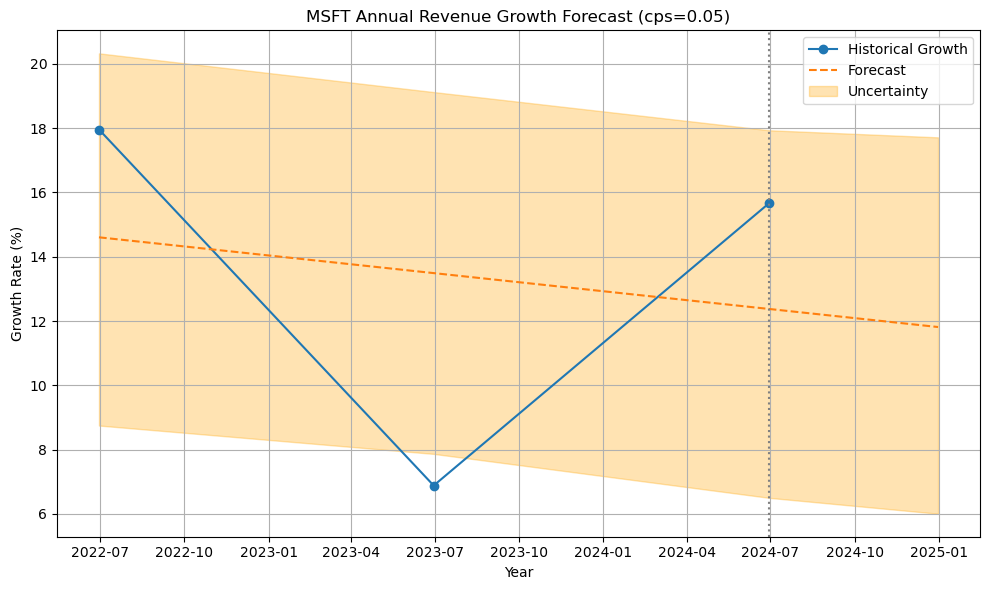

Best cps: 0.05
Next year growth: 11.81%


In [308]:
result = forecast_revenue_growth_rate_tuned("MSFT", history_years=10)
print("Best cps:", result["best_cps"])
print(f"Next year growth: {result['growth_rate']:.2f}%")

In [62]:
def forecast_next_year_revenue_growth(symbol: str, history_years: int = 10) -> dict:
    """
    Forecast Revenue Growth Rate for the next year using multivariate linear regression.
    
    Returns:
      {
        'model': fitted regression model,
        'features_used': list of feature names,
        'forecasted_growth': single float,
        'latest_predictors': dict
      }
    """
    # 1) Fetch data
    ticker = Ticker(symbol)
    inc = ticker.income_statement(frequency='a').reset_index()
    bal = ticker.balance_sheet(frequency='a').reset_index()
    cf = ticker.cash_flow(frequency='a').reset_index()

    # 2) Clean
    for df in (inc, bal, cf):
        df = df[df['periodType'] == '12M']
        df['asOfDate'] = pd.to_datetime(df['asOfDate'])

    # 3) Merge
    df = inc[['asOfDate','TotalRevenue','ResearchAndDevelopmentExpense']]\
        .merge(bal[['asOfDate','InvestedCapital','WorkingCapital']], on='asOfDate', how='left')\
        .merge(cf[['asOfDate','CapitalExpenditure','OperatingCashFlow','FreeCashFlow']], on='asOfDate', how='left')\
        .dropna().sort_values('asOfDate')

    # 4) Limit to recent history
    cutoff = df['asOfDate'].max() - pd.DateOffset(years=history_years)
    df = df[df['asOfDate'] >= cutoff]

    # 5) Feature engineering
    df['RevenueGrowth'] = df['TotalRevenue'].pct_change()
    df['R&D/Revenue'] = df['ResearchAndDevelopmentExpense'] / df['TotalRevenue']
    df['CapEx/Revenue'] = df['CapitalExpenditure'] / df['TotalRevenue']
    df['SalesToCapital'] = df['TotalRevenue'] / df['InvestedCapital']
    df['FreeCashFlowMargin'] = df['FreeCashFlow'] / df['TotalRevenue']
    df['ChangeWorkingCapital'] = df['WorkingCapital'].diff()

    predictors = ['R&D/Revenue', 'CapEx/Revenue', 'SalesToCapital', 'FreeCashFlowMargin', 'ChangeWorkingCapital']
    df[predictors] = df[predictors].shift(1)  # Lag features

    df = df.dropna()

    # 6) Prepare X and y
    X = df[predictors]
    y = df['RevenueGrowth']

    # 7) Fit model
    model = LinearRegression()
    model.fit(X, y)

    # 8) Forecast next year
    latest_features = X.iloc[-1].values.reshape(1, -1)
    next_year_growth = model.predict(latest_features)[0]

    return {
        'model': model,
        'features_used': predictors,
        'forecasted_growth': next_year_growth,
        'latest_predictors': dict(zip(predictors, X.iloc[-1]))
    }


## Value Drivers (Operating Margin)

In [13]:
def forecast_operating_margin_tuned(
    symbol: str,
    history_years: int = 10,
    cps_grid=None
) -> dict:
    """
    Forecasts next year's operating margin (%) using Prophet,
    tuning changepoint_prior_scale via time-series CV on annual data.

    Returns:
      {
        best_cps: float,
        cv_results: DataFrame,
        margin_forecast: float,    # next-year operating margin (%)
        lower_bound: float,
        upper_bound: float,
        forecast_df: DataFrame     # ds, yhat, yhat_lower, yhat_upper
      }
    """
    # default grid
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.3, 0.5]

    # 1) Pull annual statements via yahooquery
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income data for {symbol}")
    inc = inc.reset_index()
    inc12 = inc[inc['periodType']=='12M'].copy()
    inc12['asOfDate'] = pd.to_datetime(inc12['asOfDate'])
    inc12 = inc12.set_index('asOfDate').sort_index()

    # 2) Build operating margin series
    if not {'OperatingIncome','TotalRevenue'}.issubset(inc12.columns):
        raise ValueError("Required fields OperatingIncome or TotalRevenue missing")
    margin = (inc12['OperatingIncome'] / inc12['TotalRevenue']) * 100
    margin = margin.last(f"{history_years}Y").dropna()

    # 3) Prepare for Prophet
    df = margin.reset_index(name='y').rename(columns={'asOfDate':'ds'})[['ds','y']]

    # 4) Determine if tuning is feasible
    cv_results = pd.DataFrame()
    total_days = (df['ds'].max() - df['ds'].min()).days
    horizon_days = 365
    if total_days >= 2 * horizon_days:
        # compute initial window to leave horizon_days for testing
        initial_days = total_days - horizon_days
        tuning = []
        for cps in cps_grid:
            m = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=cps,
                n_changepoints=min(5, len(df)-1)
            )
            m.fit(df)
            df_cv = cross_validation(
                m,
                initial=f"{initial_days} days",
                period="365 days",
                horizon="365 days",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                'cps': cps,
                'mae': perf['mae'].mean(),
                'mape': perf['mape'].mean(),
                'rmse': perf['rmse'].mean()
            })
        cv_results = pd.DataFrame(tuning)
        best_cps = cv_results.loc[cv_results['mape'].idxmin(), 'cps']
    else:
        best_cps = 0.05

    # 5) Fit final model
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df)-1)
    )
    model.fit(df)

    # 6) Forecast next year
    future = model.make_future_dataframe(periods=1, freq='A')
    forecast = model.predict(future)
    last = forecast.iloc[-1]
    margin_forecast = last['yhat']
    lower, upper = last['yhat_lower'], last['yhat_upper']

    # 7) Visualization
    plt.figure(figsize=(10,6))
    plt.plot(df['ds'], df['y'], 'o-', label='Historical Margin')
    plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast')
    plt.fill_between(
        forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
        color='orange', alpha=0.3, label='Uncertainty'
    )
    plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
    plt.title(f"{symbol} Operating Margin Forecast (cps={best_cps})")
    plt.xlabel("Year")
    plt.ylabel("Operating Margin (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'best_cps': best_cps,
        'cv_results': cv_results,
        'margin_forecast': margin_forecast,
        'lower_bound': lower,
        'upper_bound': upper,
        'forecast_df': forecast[['ds','yhat','yhat_lower','yhat_upper']]
    }

2025-04-25 22:22:22,242 - prophet - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2025-04-25 22:22:22,243 - prophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-25 22:22:22,250 - prophet - INFO - n_changepoints greater than number of observations. Using 2.
2025-04-25 22:22:22,253 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/165teefo.json
2025-04-25 22:22:22,254 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/pxntg74u.json
2025-04-25 22:22:22,255 - cmdstanpy - DEBUG - idx 0
2025-04-25 22:22:22,255 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-04-25 22:22:22,256 - cmdstanpy - DEBUG - CmdStan args: ['/Users/tylerni/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66205', 'data', 'file=/var/folders/zc/mk397vzd3rndczvtnq

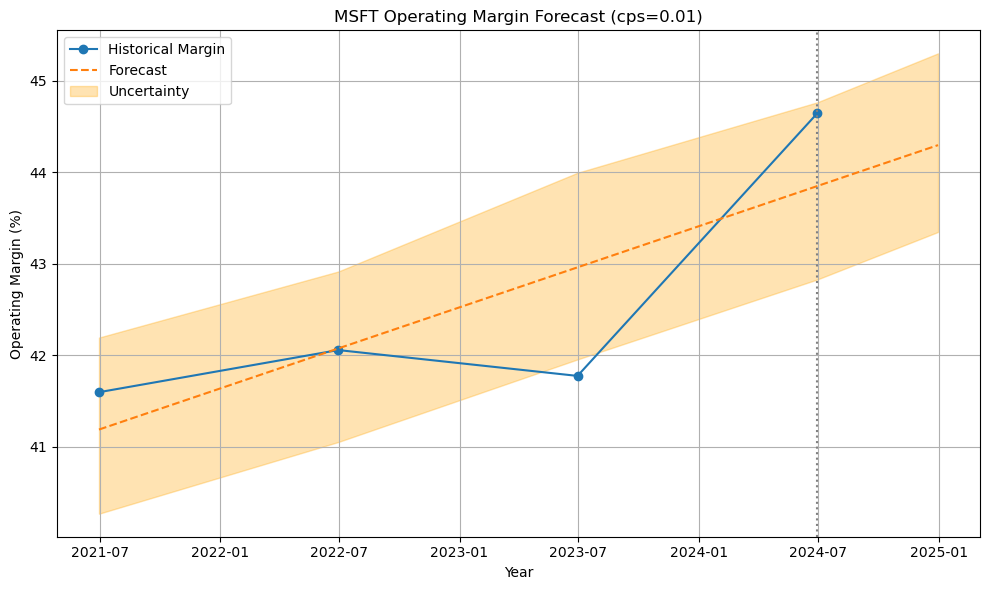

Next-year operating margin: 44.29%  (± 43.35%→45.30%)


In [323]:
res = forecast_operating_margin_tuned("MSFT", history_years=10)
print(f"Next-year operating margin: {res['margin_forecast']:.2f}%  (± {res['lower_bound']:.2f}%→{res['upper_bound']:.2f}%)")

## Value Drivers (CAGR)

In [48]:
def forecast_revenue_cagr(
    symbol: str,
    forecast_years: int = 5,
    history_years: int = 15,
    cps_grid: list = [0.05, 0.1, 0.2, 0.3, 0.5],
    growth: str = 'linear',
    plot: bool = True
) -> dict:
    """
    Forecast revenue with Prophet, auto-tuning changepoint_prior_scale (CPS).

    Args:
      symbol (str): stock ticker
      forecast_years (int): how many years forward to forecast
      history_years (int): how much historical data to use
      cps_grid (list): list of CPS values to try
      growth (str): 'linear' or 'logistic'
      plot (bool): whether to plot results

    Returns:
      dict with initial revenue, forecast revenue, CAGR, bounds, best CPS
    """
    # 1) Pull data
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income data for {symbol}")
    inc = inc.reset_index()
    inc12 = inc[inc['periodType'] == '12M'].copy()
    inc12['asOfDate'] = pd.to_datetime(inc12['asOfDate'])
    inc12 = inc12.set_index('asOfDate').sort_index()

    if 'TotalRevenue' not in inc12:
        raise ValueError("TotalRevenue not found")

    rev = inc12['TotalRevenue'].last(f"{history_years}Y").dropna()
    rev = rev[rev > 0]

    if len(rev) < 3:
        raise ValueError("Not enough revenue history for tuning")

    df = rev.reset_index(name='y').rename(columns={'asOfDate': 'ds'})[['ds', 'y']]

    # 2) Auto-tune CPS by splitting into train/validation
    errors = []
    for cps in cps_grid:
        model = Prophet(
            growth=growth,
            yearly_seasonality=False,
            changepoint_prior_scale=cps,
            n_changepoints=min(10, len(df)-1)
        )
        if growth == 'logistic':
            cap = df['y'].max() * 1.5
            df['cap'] = cap

        model.fit(df.iloc[:-1])  # train on all but last year

        future = model.make_future_dataframe(periods=1, freq='A')
        if growth == 'logistic':
            future['cap'] = cap

        forecast = model.predict(future)

        predicted = forecast['yhat'].iloc[-1]
        actual = df['y'].iloc[-1]
        error = np.abs(predicted - actual) / actual  # relative error
        errors.append((cps, error))

    # 3) Choose best CPS
    best_cps, best_error = min(errors, key=lambda x: x[1])
    print(f"Best CPS: {best_cps:.3f} with validation error: {best_error:.2%}")

    # 4) Retrain model on full data
    model = Prophet(
        growth=growth,
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(10, len(df)-1)
    )
    if growth == 'logistic':
        cap = df['y'].max() * 1.5
        df['cap'] = cap

    model.fit(df)

    future = model.make_future_dataframe(periods=forecast_years, freq='A')
    if growth == 'logistic':
        future['cap'] = cap

    forecast = model.predict(future)

    # 5) Compute CAGRs
    initial_revenue = df['y'].iloc[-1]
    forecast_row = forecast.iloc[-1]
    forecast_revenue = forecast_row['yhat']
    lower_revenue = forecast_row['yhat_lower']
    upper_revenue = forecast_row['yhat_upper']

    n = forecast_years
    cagr_forecast = (forecast_revenue / initial_revenue) ** (1/n) - 1
    lower_bound = (lower_revenue / initial_revenue) ** (1/n) - 1
    upper_bound = (upper_revenue / initial_revenue) ** (1/n) - 1

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(df['ds'], df['y'], 'o-', label='Historical Revenue')
        plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast Revenue')
        plt.fill_between(
            forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
            color='orange', alpha=0.3, label='Uncertainty'
        )
        plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
        plt.title(f"{symbol} Revenue Forecast (5 Years) [Best CPS={best_cps}]")
        plt.xlabel("Year")
        plt.ylabel("Revenue (USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'initial_revenue': initial_revenue,
        'forecast_revenue': forecast_revenue,
        'cagr_forecast': cagr_forecast * 100,
        'lower_bound': lower_bound * 100,
        'upper_bound': upper_bound * 100,
        'forecast_df': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        'best_cps': best_cps
    }

10:54:22 - cmdstanpy - INFO - Chain [1] start processing
10:54:22 - cmdstanpy - INFO - Chain [1] done processing
10:54:22 - cmdstanpy - INFO - Chain [1] start processing
10:54:22 - cmdstanpy - INFO - Chain [1] done processing
10:54:22 - cmdstanpy - INFO - Chain [1] start processing
10:54:28 - cmdstanpy - INFO - Chain [1] done processing
10:54:28 - cmdstanpy - INFO - Chain [1] start processing
10:54:32 - cmdstanpy - INFO - Chain [1] done processing
10:54:32 - cmdstanpy - INFO - Chain [1] start processing
10:54:37 - cmdstanpy - INFO - Chain [1] done processing
10:54:37 - cmdstanpy - INFO - Chain [1] start processing
10:54:37 - cmdstanpy - INFO - Chain [1] done processing


Best CPS: 0.050 with validation error: 8.05%


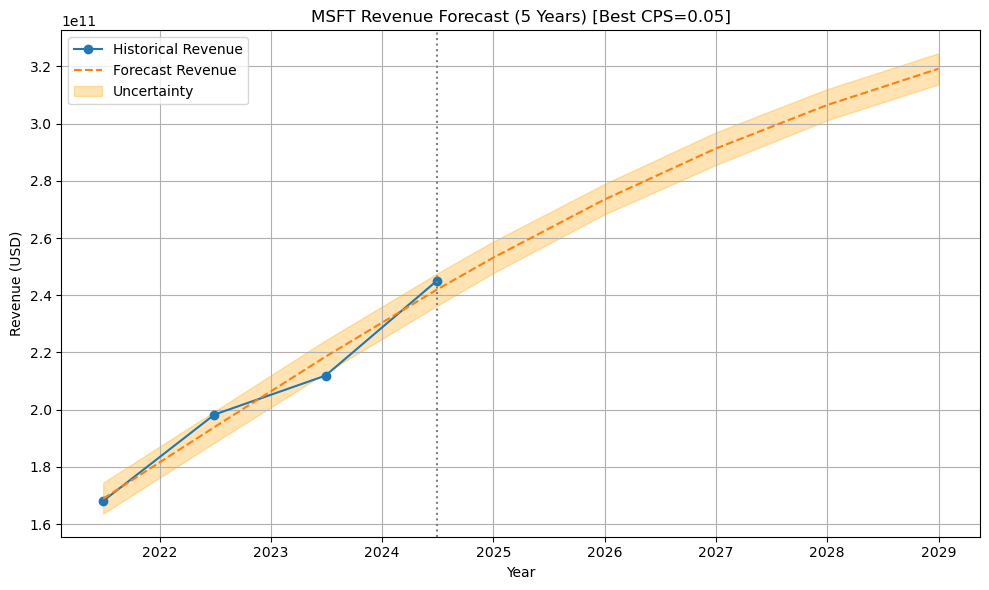

5-Year Forecasted CAGR: 5.42%
90% confidence: 5.06% → 5.78%
Tuned CPS: 0.05


In [50]:
result = forecast_revenue_cagr(
    "MSFT",
    forecast_years=5,
    growth='logistic'
)

print(f"5-Year Forecasted CAGR: {result['cagr_forecast']:.2f}%")
print(f"90% confidence: {result['lower_bound']:.2f}% → {result['upper_bound']:.2f}%")
print(f"Tuned CPS: {result['best_cps']:.2f}")

## Value Drivers (Target Pre-Tax Operating Margin, Years to Convergence)

In [ ]:
def forecast_operating_margin(symbol: str, history_years: int = 5) -> dict:
    """
    Forecasts the Target Pre-Tax Operating Margin and estimates
    how many years it'll take to converge.

    Returns:
      {
        'current_margin': float (%),
        'target_margin': float (%),
        'annual_change': float (%/year),
        'years_to_converge': float,
        'margin_trend_df': DataFrame
      }
    """
    # 1. Pull financials
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income statement data for {symbol}")
    
    inc = inc.reset_index()
    inc = inc.sort_values('asOfDate')
    
    # 2. Calculate operating margin
    inc['operating_margin'] = inc['EBIT'] / inc['TotalRevenue']
    inc = inc.dropna(subset=['operating_margin'])
    
    # 3. Limit to recent history
    inc['asOfDate'] = pd.to_datetime(inc['asOfDate'])
    inc = inc.set_index('asOfDate')
    recent = inc.last(f"{history_years}Y")
    
    if len(recent) < 2:
        raise ValueError("Not enough historical margin data for trend estimation.")

    # 4. Fit linear trend (year vs margin)
    X = recent.index.year.values.reshape(-1,1)
    y = recent['operating_margin'].values

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]   # margin change per year
    intercept = model.intercept_

    # 5. Forecast target margin (say, extrapolate +5 years ahead)
    future_year = X[-1][0] + 5
    target_margin = model.predict(np.array([[future_year]]))[0]

    # 6. Current margin
    current_margin = y[-1]

    # 7. Time to converge
    if np.isclose(slope, 0):
        years_to_converge = np.inf  # Never converges
    else:
        years_to_converge = (target_margin - current_margin) / slope

    # 8. Package results
    margin_trend_df = pd.DataFrame({'year': X.flatten(), 'operating_margin': y})

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(recent.index.year, recent['operating_margin'], 'o-', label='Historical Operating Margin', color='blue')
    plt.plot(recent.index.year, model.predict(X), '--', label='Regression Line', color='green')
    plt.axvline(future_year, color='red', linestyle=':', label=f'Forecast for {future_year}')
    plt.scatter(future_year, target_margin, color='red', zorder=5)
    plt.text(future_year, target_margin, f'Target Margin: {target_margin*100:.2f}%', 
             verticalalignment='bottom', horizontalalignment='right', color='red')
    
    plt.title(f'{symbol} Operating Margin Forecast and Convergence')
    plt.xlabel('Year')
    plt.ylabel('Operating Margin (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'current_margin': current_margin * 100,
        'target_margin': target_margin * 100,
        'annual_change': slope * 100,
        'years_to_converge': years_to_converge,
        'margin_trend_df': margin_trend_df
    }


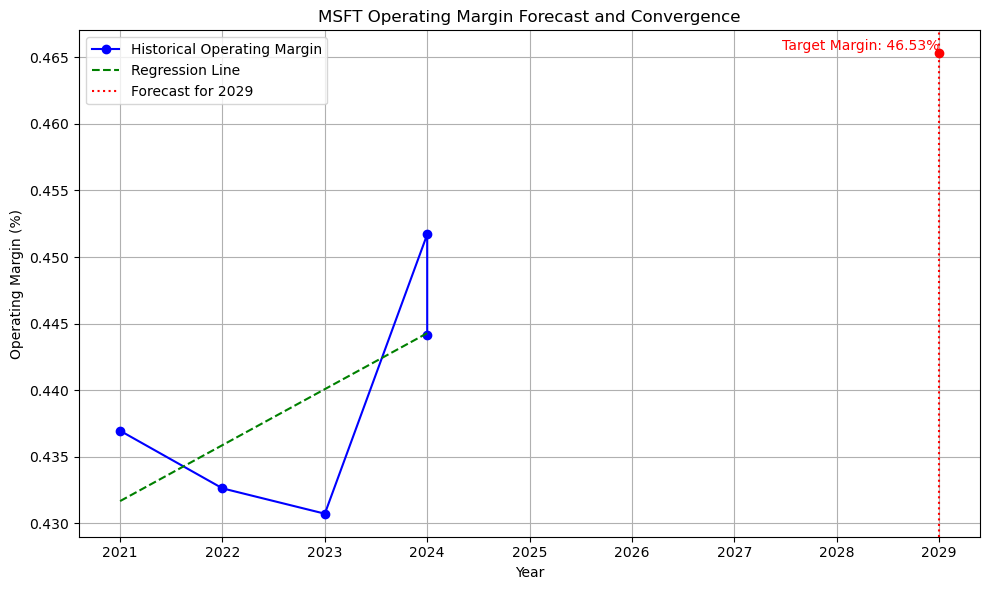

Current Margin: 44.42%
Target Margin (5yr): 46.53%
Annual Change: 0.42% per year
Years to Converge: 5.0 years


In [55]:
result = forecast_operating_margin('MSFT')

print(f"Current Margin: {result['current_margin']:.2f}%")
print(f"Target Margin (5yr): {result['target_margin']:.2f}%")
print(f"Annual Change: {result['annual_change']:.2f}% per year")
print(f"Years to Converge: {result['years_to_converge']:.1f} years")

## Value Drivers (Sales to Capital Ratio)

In [ ]:
def forecast_sales_to_capital_ratio(
    symbol: str,
    history_years: int = 15,
    cps: float = 0.05
) -> dict:
    """
    Forecasts the sales-to-capital ratio (Revenue / InvestedCapital) for
    the next 1–5 years and 6–10 years using Prophet.

    Returns:
      {
        'avg_1_5': float,      # average ratio for years 1–5
        'avg_6_10': float,     # average ratio for years 6–10
        'forecast_df': DataFrame  # full 10-year forecast with yhat, yhat_lower, yhat_upper
      }
    """
    # 1) Fetch annual data
    ticker = Ticker(symbol)
    inc = ticker.income_statement(frequency='a').reset_index()
    bal = ticker.balance_sheet(frequency='a').reset_index()

    # 2) Keep only 12M rows and parse dates
    inc = inc[inc['periodType'] == '12M'].copy()
    bal = bal[bal['periodType'] == '12M'].copy()
    inc['asOfDate'] = pd.to_datetime(inc['asOfDate'])
    bal['asOfDate'] = pd.to_datetime(bal['asOfDate'])

    # 3) Merge Revenue & InvestedCapital on date
    df = pd.merge(
        inc[['asOfDate','TotalRevenue']],
        bal[['asOfDate','InvestedCapital']],
        on='asOfDate',
        how='inner'
    ).sort_values('asOfDate')

    # 4) Limit to the last history_years (drop any nulls)
    cutoff = df['asOfDate'].max() - pd.DateOffset(years=history_years)
    df = df[df['asOfDate'] >= cutoff].dropna(subset=['TotalRevenue','InvestedCapital'])

    # 5) Compute the ratio
    df['ratio'] = df['TotalRevenue'] / df['InvestedCapital']

    # 6) Prepare for Prophet
    df_prophet = df[['asOfDate','ratio']].rename(columns={'asOfDate':'ds','ratio':'y'})

    # 7) Fit Prophet
    m = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=cps
    )
    m.fit(df_prophet)

    # 8) Forecast 10 years ahead (1–10)
    future = m.make_future_dataframe(periods=10, freq='A')
    fc = m.predict(future)

    # 9) Extract just the 10 forecast points (after the last historical year)
    last_hist = df_prophet['ds'].max()
    fut = fc[fc['ds'] > last_hist].reset_index(drop=True)

    # 10) Compute averages for years 1–5 and 6–10
    avg_1_5  = fut.loc[0:4, 'yhat'].mean()
    avg_6_10 = fut.loc[5:9, 'yhat'].mean()

    # 11) Plot historical + forecast
    plt.figure(figsize=(10,5))
    plt.plot(df_prophet['ds'], df_prophet['y'], 'o-', label='Historical Ratio')
    plt.plot(fut['ds'], fut['yhat'], '--', label='Forecast Ratio')
    plt.fill_between(fut['ds'], fut['yhat_lower'], fut['yhat_upper'],
                     color='orange', alpha=0.3, label='Uncertainty')
    plt.axvline(last_hist, color='gray', linestyle=':')
    plt.title(f"{symbol} Sales-to-Capital Ratio Forecast")
    plt.xlabel("Year")
    plt.ylabel("Revenue / Invested Capital")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'avg_1_5':  avg_1_5,
        'avg_6_10': avg_6_10,
        'forecast_df': fut[['ds','yhat','yhat_lower','yhat_upper']]
    }

11:06:03 - cmdstanpy - INFO - Chain [1] start processing
11:06:03 - cmdstanpy - INFO - Chain [1] done processing


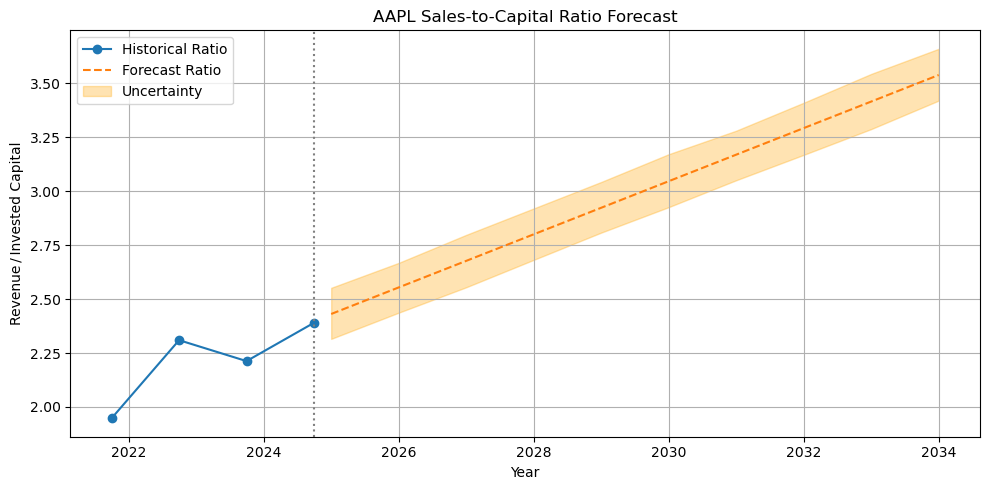

Sales→Capital (Years 1–5): 2.68
Sales→Capital (Years 6–10): 3.29


In [61]:
res = forecast_sales_to_capital_ratio("AAPL", history_years=10, cps=0.1)
print(f"Sales→Capital (Years 1–5): {res['avg_1_5']:.2f}")
print(f"Sales→Capital (Years 6–10): {res['avg_6_10']:.2f}")

In [56]:
rev_growth_rate_for_next_year = input('What is the revenue growth rate for the next year?')
operating_margin_for_next_year = input('What is the operating margin for the next year?')
compounded_annual_growth_rate = input('What is the compounded annual growth rate?')
target_pre_tax_operating_margin = input('What is the target pre-tax operating margin?')
years_of_convergence_for_margin = input('How many years of convergence for the margin?')
sales_to_capital_ratio_for_years_1_to_5 = input('What is the sales to capital ratio for the first 5 years?')
sales_to_capital_ratio_for_years_6_to_10 = input('What is the sales to capital ratio for the last 5 years?')
input_worksheet.update('B26', [[rev_growth_rate_for_next_year]])
input_worksheet.update('B27', [[operating_margin_for_next_year]])
input_worksheet.update('B28', [[compounded_annual_growth_rate]])
input_worksheet.update('B29', [[target_pre_tax_operating_margin]])
input_worksheet.update('B30', [[years_of_convergence_for_margin]])
input_worksheet.update('B31', [[sales_to_capital_ratio_for_years_1_to_5]])
input_worksheet.update('B32', [[sales_to_capital_ratio_for_years_6_to_10]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/306207704.py:8: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B26', [[rev_growth_rate_for_next_year]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/306207704.py:9: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B27', [[operating_margin_for_next_year]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/306207704.py:10: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B28', [[compounded_annual_growth_rate]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B32",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Market Numbers

In [140]:
rf = financials["B33"]
input_worksheet.update('B33', [[rf]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_39120/1984852254.py:2: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B33', [[rf]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B33",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Other Inputs

In [141]:
valuation_worksheet.acell('B33').value

' $ (55.97)'